<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Modelo_de_Clasificacion_ngrams_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Librerias

import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as plt
import nltk
import string
import itertools
from nltk import word_tokenize
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers, backend
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from sklearn. preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Using TensorFlow backend.


# Define algunas características iniciales

In [3]:
vocab_size = 23121 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 111  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [4]:
a = np.array([32]) # space
c = np.array(range(97,123)) # minúsculas
printab = np.hstack((a,c))
printable = np.array([chr(i) for i in printab])   
printable 

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

## Lectura de los datos

In [5]:
complete_sentences = [] #
complete_lines = [] 
sentences = []
labels = [] # etiquetas preprocesadas
stopwords = []

In [6]:
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
#file = open('/content/drive/My Drive/Colab Notebooks/DFSMS.csv', 'r') #David
#file = open('/content/drive/My Drive/Simpsons Chat bot/chatbot_simpsons-master/Datos/DFSMS.csv', 'r') #Julieth
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))

69171
69171
69171
69171


In [7]:
# Primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Tercer linea
print(labels[2]+'\n')
print(complete_sentences[2]+'\n')
print(complete_lines[2]+'\n')
print(sentences[2]+'\n')

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom

bart_simpson

victory party under the slide

Bart Simpson: Victory party under the slide!

victory party under the slide



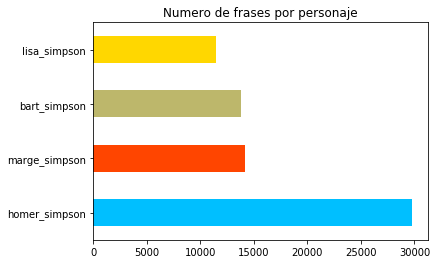

In [8]:
# Gráfico de barras de numero de frases por personaje
frec = pd.value_counts(labels)
plot = frec.plot(kind='barh',title='Numero de frases por personaje',color=['deepskyblue','orangered','darkkhaki','gold'])

# Separa datos de entrenamiento y validación 

In [9]:
train_size = int(len(sentences) * training_portion)
train_size # 80%

55336

#### Grupo de entrenamiento

In [10]:
train_sentences = sentences[:train_size] # Frases de entrenamiento 
train_labels = labels[:train_size] # Etiquetas de entrenamiento
print(len(train_sentences)) # Tamaño de frases de entrenamiento
print(len(train_labels)) # Tamaño de etiquetas de entrenamiento
print(train_sentences[:3]) 
print(train_labels[:3])

55336
55336
['wheres mr bergstrom', 'that life is worth living', 'victory party under the slide']
['lisa_simpson', 'lisa_simpson', 'bart_simpson']


#### Grupo de validación

In [11]:
validation_sentences = sentences[train_size:] # Frases de validacion
validation_labels = labels[train_size:] # Frases de validacion
print(len(validation_sentences)) # Tamaño de frases de validacion
print(len(validation_labels)) # Tamaño de etiquetas de validacion
print(validation_sentences[:3]) 
print(validation_labels[:3])

13835
13835
['', 'someone snitched whawhawhawhawhat are you gonna do to me', 'up or down']
['homer_simpson', 'homer_simpson', 'homer_simpson']


# Grafica de frecuencia de n-gramas
### Trigramas

In [12]:
#Juntamos todo el texto en una sola linea
wordtk = ' '.join(train_sentences)

#Para dividir las frases
tokenstk = regexp_tokenize(wordtk, pattern="\w+")
tokenstk[:10]

['wheres',
 'mr',
 'bergstrom',
 'that',
 'life',
 'is',
 'worth',
 'living',
 'victory',
 'party']

In [13]:
from nltk.util import ngrams
trigrama = ngrams(tokenstk,3)
trigrama = [' '.join(grams) for grams in trigrama]
trigrama[:5]

['wheres mr bergstrom',
 'mr bergstrom that',
 'bergstrom that life',
 'that life is',
 'life is worth']

In [14]:
freq = nltk.FreqDist(trigrama) #frecuencia de los tokens

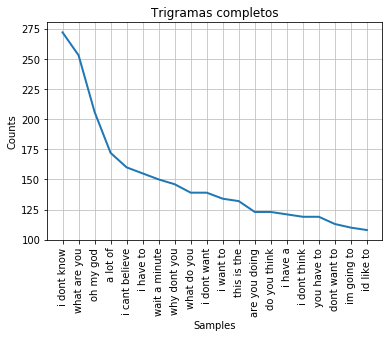

Trigramas completos unicos: 380603


In [15]:
# Gráfica con los trigramas COMPLETOS
freq.plot(20, cumulative=False, title = "Trigramas completos")
print("Trigramas completos unicos:", len(freq))

In [16]:
eliminar = [] #filtramos tokens que se repiten mas de una vez
for key,val in freq.items():
  if (250>val>3):
    eliminar.append(str(key))

trigrama_limpio = []
for i in trigrama:
  if i in eliminar:
    trigrama_limpio.append(i)

freqnew = nltk.FreqDist(trigrama_limpio)

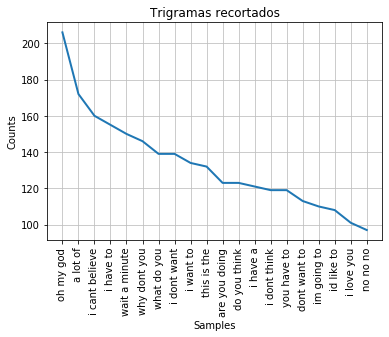

Trigramas recortados unicos: 8725


In [17]:
# Gráfica con los trigramas RECORTADOS
freqnew.plot(20, cumulative=False, title = "Trigramas recortados")
print("Trigramas recortados unicos:", len(freqnew))

In [18]:
print("Trigramas_limpios:",len(trigrama_limpio))
print("Trigramas unicos con sus frecuencias:",len(freqnew))

Trigramas_limpios: 70547
Trigramas unicos con sus frecuencias: 8725


### Bigramas

In [19]:
from nltk.util import ngrams
bigrama = ngrams(tokenstk,2)
bigrama = [' '.join(grams) for grams in bigrama]
bigrama[:5]

['wheres mr', 'mr bergstrom', 'bergstrom that', 'that life', 'life is']

In [20]:
freqb = nltk.FreqDist(bigrama) #frecuencia de los tokens

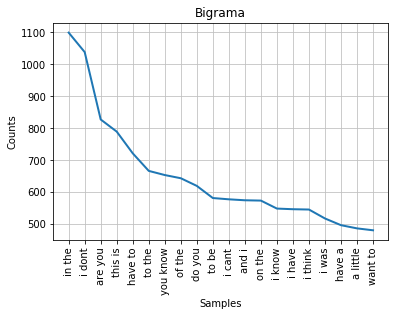

Bigramas completos unicos: 193111


In [21]:
# Gráfica con los bigramas COMPLETOS
freqb.plot(20, cumulative=False, title = "Bigrama")
print("Bigramas completos unicos:", len(freqb))

In [22]:
eliminarb = [] #filtramos tokens que se repiten mas de una vez
for key,val in freqb.items():
  if (700>val>100):
    eliminarb.append(str(key))

bigrama_limpio = []
for i in bigrama:
  if i in eliminarb:
    bigrama_limpio.append(i)

freqbnew = nltk.FreqDist(bigrama_limpio)

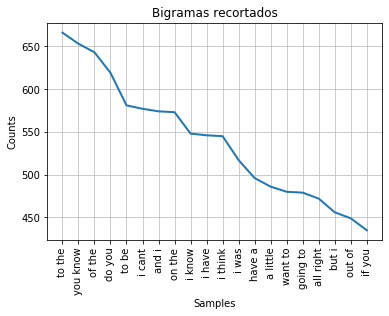

Bigramas recortados unicos: 8725


In [23]:
# Gráfica con los Bigramas
freqbnew.plot(20, cumulative=False, title = "Bigramas recortados")
print("Bigramas recortados unicos:", len(freqnew))

In [24]:
print("Bigramas_limpios:",len(bigrama_limpio))
print("Bigramas unicos con sus frecuencias:",len(freqbnew))

Bigramas_limpios: 64008
Bigramas unicos con sus frecuencias: 317


# Vocabulario
### Trigramas

Aunque trigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqnew.keys() que contiene los tokens unicos.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer3 = CountVectorizer(vocabulary=freqnew.keys(), ngram_range=(3,3))

In [26]:
X3 = vectorizer3.fit_transform(train_sentences)
X3

<55336x8725 sparse matrix of type '<class 'numpy.int64'>'
	with 47115 stored elements in Compressed Sparse Row format>

In [27]:
F3 = vectorizer3.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F3[:10]

['do you know',
 'you know where',
 'know where i',
 'i could find',
 'hey thanks for',
 'thanks for your',
 'you got that',
 'got that right',
 'a couple of',
 'just going to']

In [28]:
train_sequences = X3.toarray() #arreglo
print("longitud",len(X3.toarray()))

longitud 55336


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un trigrama, por lo tanto la tabla es de (55336 × 8725),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 8725

In [29]:
import pandas as pd
pd.DataFrame(train_sequences,columns=vectorizer3.get_feature_names())

,do you know,you know where,know where i,i could find,hey thanks for,thanks for your,you got that,got that right,a couple of,just going to,...,the chosen one,zap zap zap,ew ew ew,you like potato,you like tomato,fine fine fine,wont tell me,a farm upstate,cheech and chong,daves not here
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bigramas
Aunque bigrama_limpio ya no tiene ni los tokens con repitencias muy bajas ni muy altas, contiene tokens repetidos, por eso, para el vocabulario de CountVectorizer utilizameros los freqbnew.keys() que contiene los tokens unicos.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(vocabulary=freqbnew.keys(), ngram_range=(2,2))

In [31]:
X2 = vectorizer2.fit_transform(train_sentences)
X2

<55336x317 sparse matrix of type '<class 'numpy.int64'>'
	with 42308 stored elements in Compressed Sparse Row format>

In [32]:
F2 = vectorizer2.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
F2[:10]

['do you',
 'you know',
 'i could',
 'i see',
 'for your',
 'you got',
 'as a',
 'oh i',
 'i mean',
 'you just']

In [33]:
train_sequences_b = X2.toarray() #arreglo
print("longitud",len(X2.toarray()))

longitud 55336


Como vemos en la tabla, cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a un bigrama, por lo tanto la tabla es de (55336 × 317),

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias: 317

In [34]:
import pandas as pd
pd.DataFrame(train_sequences_b,columns=vectorizer2.get_feature_names())

,do you,you know,i could,i see,for your,you got,as a,oh i,i mean,you just,...,youre not,not a,am i,got to,id like,make it,wanted to,what the,i wont,like the
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Datos Entrenamiento
### Juntamos los bigramas y trigramas
Como cada fila corresponde a una frase de nuestro __train_sentences__ y cada columna corresponde a los bigramas y trigramas, nuestra tabla es de (55336 × 9042) donde:

  - train_sentences: 55336
  - Trigramas unicos con sus frecuencias(8725) + bigramas unicos con sus frecuencias(317):  9042

In [35]:
train_sequences_bt = np.concatenate((train_sequences, train_sequences_b), axis=1)
#tamaño de los datos
type(train_sequences_bt)

numpy.ndarray

In [36]:
train_sequences_bt[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [37]:
train_sequences_bt_new = [ ]
train_labels_new = [ ]
for i in range(0,len(train_sequences_bt)):
  if sum(train_sequences_bt[i,]) != 0:
    train_labels_new.append(train_labels[i])
    train_sequences_bt_new.append(train_sequences_bt[i,])

train_sequences_bt = np.array(train_sequences_bt_new)

In [38]:
train_labels = train_labels_new
print(np.shape(train_sequences_bt))
print(np.shape(train_labels))

(29436, 9042)
(29436,)


# Datos Validacion
### Trigramas

In [39]:
X6 = vectorizer3.fit_transform(validation_sentences)
F6 = vectorizer3.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
validation_sequences = X6.toarray() #arreglo
print("longitud",len(X6.toarray()))
print(X6.toarray().shape)

longitud 13835
(13835, 8725)


### Bigramas

In [40]:
X4 = vectorizer2.fit_transform(validation_sentences)
F4 = vectorizer2.get_feature_names() #Mapeo de matriz de índices de enteros a nombres.
validation_sequences_b = X4.toarray() #arreglo
print(X4.toarray().shape)

(13835, 317)


### Juntamos trigramas y bigramas

In [41]:
validation_sequences_bt = np.concatenate((validation_sequences, validation_sequences_b), axis=1)
#tamaño de los datos
validation_sequences_bt.shape

(13835, 9042)

In [42]:
validation_sequences_bt_new = [ ]
validation_labels_new = [ ]
for i in range(0,len(validation_sequences_bt)):
  if sum(validation_sequences_bt[i,]) != 0:
    validation_labels_new.append(validation_labels[i])
    validation_sequences_bt_new.append(validation_sequences_bt[i,])

validation_sequences_bt = np.array(validation_sequences_bt_new)

In [43]:
validation_labels = validation_labels_new
print(np.shape(validation_sequences_bt))
print(np.shape(validation_labels))

(7069, 9042)
(7069,)


# Labels
### Entrenamiento

In [44]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(train_labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
training_label_seq[:5]
print(len(training_label_seq))

29436


In [45]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
train_labels = encoder.transform(training_label_seq)

In [46]:
# Codificación One-Hot 
num_classes = label_size
train_labels_codf = tf.keras.utils.to_categorical(train_labels, num_classes)

In [47]:
len(train_labels_codf)

29436

In [48]:
print(train_labels_codf)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


#### Grupo de Validacion 

In [49]:
label_size = 4
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(validation_labels)
label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])
validation_label_seq
print(len(validation_label_seq))

7069


In [50]:
#Creamos etiquetas numericas
encoder = LabelEncoder()

encoder.fit(label_seq)
validation_labels = encoder.transform(validation_label_seq)
num_classes = 4

In [51]:
# Codificación One-Hot 
validation_labels_codf = tf.keras.utils.to_categorical(validation_labels, num_classes)

In [52]:
len(validation_labels_codf)

7069

In [53]:
print(validation_labels_codf)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


# Construccion del Modelo

In [54]:
print(np.shape(train_labels_codf))
print(np.shape(train_sequences_bt))
print(np.shape(validation_labels_codf))
print(np.shape(validation_sequences_bt))

(29436, 4)
(29436, 9042)
(7069, 4)
(7069, 9042)


In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6028, activation='relu', input_shape=(9042,)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(4521, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2260, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1130,activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l1(1e-5),
                              activity_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6028)              54511204  
_________________________________________________________________
dropout (Dropout)            (None, 6028)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4521)              27257109  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4521)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2260)              10219720  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2260)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1130)              2

# Entrenamiento del modelo

|dropout|F. de activación| dense |loss_train |accuracy_train |loss_validation |accuracy_validation |Ephoc|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|4|tanh(1),relu(3)|5|0.7715|0.6028|1.2662|0.4657|7|
|4|tanh(4),relu(1)|6|0.9419|0.5285|1.1128|0.4241|6|
|5|tanh(2),relu(3)|6|0.7683|0.6877|1.7956|0.4490|10|
|5|tanh(0),relu(5)|6|0.4636|0.7820|2.1792|0.4489|10|

In [56]:
num_epochs = 10
history = model.fit(train_sequences_bt, train_labels_codf, epochs=num_epochs, validation_data=(validation_sequences_bt,validation_labels_codf),batch_size=1000 , verbose=True)

Train on 29436 samples, validate on 7069 samples
Epoch 1/10
29436/29436 [==============================] - 173s 6ms/sample - loss: 1.5735 - accuracy: 0.3954 - val_loss: 1.3708 - val_accuracy: 0.4463
Epoch 2/10
29436/29436 [==============================] - 164s 6ms/sample - loss: 1.2834 - accuracy: 0.4369 - val_loss: 1.2215 - val_accuracy: 0.4494
Epoch 3/10
29436/29436 [==============================] - 160s 5ms/sample - loss: 1.0498 - accuracy: 0.5729 - val_loss: 1.1781 - val_accuracy: 0.4626
Epoch 4/10
29436/29436 [==============================] - 159s 5ms/sample - loss: 0.8633 - accuracy: 0.6630 - val_loss: 1.2397 - val_accuracy: 0.4565
Epoch 5/10
29436/29436 [==============================] - 159s 5ms/sample - loss: 0.7286 - accuracy: 0.7163 - val_loss: 1.3433 - val_accuracy: 0.4622
Epoch 6/10
29436/29436 [==============================] - 158s 5ms/sample - loss: 0.6322 - accuracy: 0.7474 - val_loss: 1.5201 - val_accuracy: 0.4384
Epoch 7/10
29436/29436 [===========================

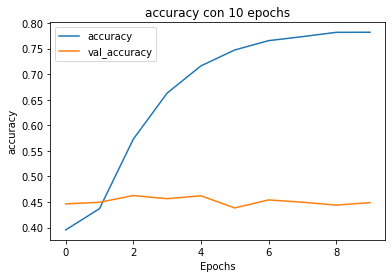

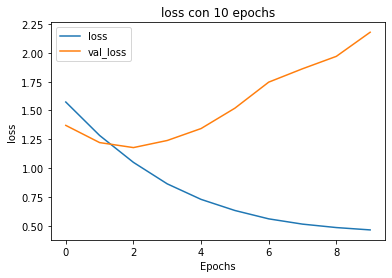

In [57]:
def plot_graphs(history, string):
  plt.title(string+' con 10 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")